<a href="https://colab.research.google.com/github/christinezuzart/DeepLearning/blob/master/NLPULMFitGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

Saving drugsComTest_raw.csv to drugsComTest_raw.csv
Saving drugsComTrain_raw.csv to drugsComTrain_raw.csv


In [0]:
import pandas as pd
import io

dfTrain = pd.read_csv(io.StringIO(uploaded['drugsComTest_raw.csv'].decode('utf-8')))
dfTest = pd.read_csv(io.StringIO(uploaded['drugsComTrain_raw.csv'].decode('utf-8')))

train_texts = dfTrain.loc[ : , 'review'].values
train_labels = dfTrain.loc[ : , 'condition'].values

test_texts = dfTest.loc[ : , 'review'].values
test_labels = dfTest.loc[ : , 'condition'].values

col_names = ['labels','text']
df_train = pd.DataFrame({'text':train_texts, 'labels':train_labels}, columns=col_names)
df_test = pd.DataFrame({'text':test_texts, 'labels':test_labels}, columns=col_names)

df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

unique_train_labels_list = df_train.labels.unique()
unique_test_labels_list = df_test.labels.unique()



In [3]:
df_test_new = pd.DataFrame(columns=['labels','text'])
for ind in df_test.index: 
  if df_test['labels'][ind] in unique_train_labels_list :
   new_row = {'labels': df_test['labels'][ind], 'text':df_test['text'][ind]}
   df_test_new = df_test_new.append(new_row, ignore_index=True)

print(df_test_new.head())

                         labels                                               text
0  Left Ventricular Dysfunction  "It has no side effect, I take it in combinati...
1                          ADHD  "My son is halfway through his fourth week of ...
2                 Birth Control  "I used to take another oral contraceptive, wh...
3                 Birth Control  "This is my first time using any form of birth...
4             Opiate Dependence  "Suboxone has completely turned my life around...


In [0]:
# a = df_test_new.labels.unique()
# print('\n'.join(map(str, a)))

In [0]:
from fastai.text import *

# Language model data
data_lm = TextLMDataBunch.from_df('./', train_df=df_train, valid_df=df_test_new)

In [0]:
# Language model
lang_learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


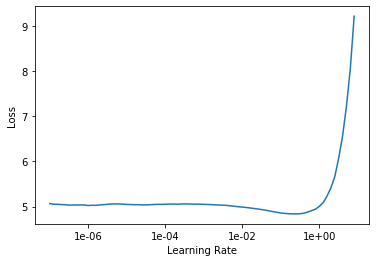

In [7]:
lang_learner.lr_find(start_lr=1e-8, end_lr=1e2)
lang_learner.recorder.plot()

In [8]:
lang_learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
lang_learner.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

lang_learner.unfreeze() 
lang_learner.fit_one_cycle(2, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.857413,3.681069,0.290681,22:07


epoch,train_loss,valid_loss,accuracy,time
0,3.382216,3.260805,0.340298,24:42
1,3.213693,3.159980,0.353125,24:40


In [0]:
lang_learner.save_encoder('fine_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./', train_df=df_train, valid_df=df_test_new, vocab=data_lm.train_ds.vocab, min_freq=1, bs=32)

In [0]:
# Classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


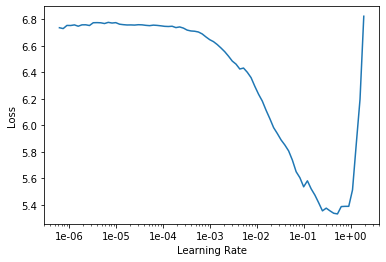

In [12]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_enc')

learn.freeze()
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.656560,2.280760,0.517231,19:31


In [16]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.118899,1.847632,0.591727,29:35
1,1.648052,1.540924,0.644749,29:19
2,1.390293,1.417370,0.672970,30:11


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.388839,1.440297,0.673458,20:33


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.321799,1.426418,0.679198,25:01


In [19]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.264797,1.424710,0.681512,27:49
1,1.327090,1.398366,0.685814,30:14
2,1.185883,1.403701,0.690354,27:48
3,1.132348,1.387314,0.691561,29:55


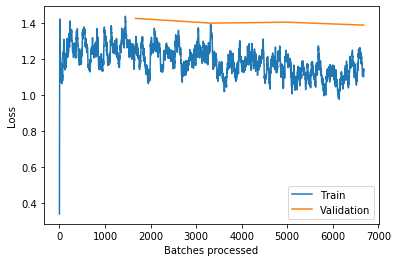

In [20]:
learn.recorder.plot_losses()

In [0]:
learn.export()

In [22]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,31,32,33,34,35,36,37,38,40,42,43,44,45,46,...,666,667,668,669,670,671,672,673,674,675,676,677,678,679,681,682,683,684,685,686,687,688,689,690,691,692,693,695,696,697,698,699,700,701,702,703,704,705,706,707
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44,1,1,0,0,0,0,1,2,1,0,0,0,2,2,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,2965,1,0,...,0,0,0,0,0,1,0,0,0,0,9,0,0,0,0,0,0,0,0,11,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0
46,2,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,964,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
49,1,1,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,2,0,0,1,1,1,0,0,0,0,2,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
692,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,11,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1264,0,0,0,0,0,0,0,0,0,0,0,0,0,0
696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,140,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# from fastai.vision import *

# preds, y, losses = learn.get_preds(with_loss = 1)
print(f"softmax predictions: {preds}")
print(f"indexed predictions:{predictions}")
print(f"targets:{targets}")

softmax predictions: tensor([[1.1177e-04, 4.8905e-09, 9.4790e-09,  ..., 4.1949e-09, 1.3170e-06,
         9.5008e-07],
        [3.4904e-05, 1.3552e-09, 2.3908e-09,  ..., 9.0101e-10, 3.2567e-07,
         3.4303e-07],
        [5.2162e-08, 1.5688e-11, 1.8579e-11,  ..., 7.8530e-12, 8.2374e-09,
         2.6550e-08],
        ...,
        [5.4244e-04, 5.3269e-08, 1.1697e-07,  ..., 3.5054e-08, 2.0744e-05,
         3.1275e-05],
        [5.3990e-04, 6.6220e-08, 1.2545e-07,  ..., 4.0712e-08, 2.7477e-05,
         6.4669e-05],
        [7.0963e-04, 3.2598e-08, 5.9934e-08,  ..., 1.6792e-08, 1.8107e-05,
         2.6752e-05]])
indexed predictions:tensor([201, 448, 236,  ..., 201, 244, 478])
targets:tensor([402, 448, 236,  ...,  87, 569, 414])


In [24]:
class_names = learn.data.classes
print(class_names)

['0</span> users found this comment helpful.', '100</span> users found this comment helpful.', '105</span> users found this comment helpful.', '10</span> users found this comment helpful.', '11</span> users found this comment helpful.', '12</span> users found this comment helpful.', '135</span> users found this comment helpful.', '13</span> users found this comment helpful.', '14</span> users found this comment helpful.', '15</span> users found this comment helpful.', '16</span> users found this comment helpful.', '17</span> users found this comment helpful.', '18</span> users found this comment helpful.', '1</span> users found this comment helpful.', '20</span> users found this comment helpful.', '21</span> users found this comment helpful.', '22</span> users found this comment helpful.', '23</span> users found this comment helpful.', '24</span> users found this comment helpful.', '25</span> users found this comment helpful.', '27</span> users found this comment helpful.', '28</span> 

In [26]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(targets, predictions)
print(confusion_matrix)


[[0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 ...
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]]


In [0]:
# metrics.classification_report(targets, predictions, target_names=class_names)
# metrics.classification_report(targets, predictions, target_names=unique_train_labels_list)

In [0]:
# interp = ClassificationInterpretation(learn, preds, y, losses)

# interp.plot_confusion_matrix()

In [32]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [37]:
model_save_name = 'export.pkl'
path = F"/content/gdrive/My Drive/{model_save_name}" 
print(path)
learn.export(path)

/content/gdrive/My Drive/export.pkl


In [38]:
learn.save("trained_model", return_path=True)

PosixPath('models/trained_model.pth')

In [0]:
# model_save_name = 'export.pkl'
# path = F"/content/gdrive/My Drive/{model_save_name}" 

# saved_learner = load_learner(path)

# saved_learner.predict("")